In [ ]:
!pip install ecmwflibs
!pip install eccodes
!pip install cfgrib
!pip install xarray
!pip install cartopy

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime
import cartopy.crs as ccrs
import numpy as np

In [14]:
members = [
    "gec00", "gep01", "gep02", "gep03", "gep04", "gep05",
    "gep06", "gep07", "gep08", "gep09", "gep10",
    "gep11", "gep12", "gep13", "gep14", "gep15",
    "gep16", "gep17", "gep18", "gep19", "gep20",
    "gep21", "gep22", "gep23", "gep24", "gep25",
    "gep26", "gep27", "gep28", "gep29", "gep30"
]
# ftimes = ["{:03d}".format(i) for i in range(0, 9, 3)]  # forecast times
ftime = 24
init_date = datetime(2023, 12, 3, 0)  # model initial time, year month date hour
local_dir = f"/content/drive/MyDrive/Bahan_training/apcp/{init_date:%Y%m%d%H}"

Try to open one file

In [ ]:
member = "gec00" # Change the member if needed
fname = f"{member}.t{init_date:%H}z.pgrb2s.0p25.f{ftime:03}.grb2"
ds = xr.open_dataset(f"{local_dir}/{fname}",engine="cfgrib")
ds

In [ ]:
ds["tp"].plot()

Normally for the precipitation parameter, the model will accumulate the precip until the end of the forecast time.
But for GEFS the precipitation will accumulate every 6h and then resets. Hence, if we need to have precipitation accumulated for 24h, we need to take forecast 06,12,18,24 hour.

In [ ]:
#Define the filename
f1 = f"{local_dir}/{member}.t{init_date:%H}z.pgrb2s.0p25.f{ftime:03}.grb2"
f2 = f"{local_dir}/{member}.t{init_date:%H}z.pgrb2s.0p25.f{ftime-6:03}.grb2"
f3 = f"{local_dir}/{member}.t{init_date:%H}z.pgrb2s.0p25.f{ftime-12:03}.grb2"
f4 = f"{local_dir}/{member}.t{init_date:%H}z.pgrb2s.0p25.f{ftime-18:03}.grb2"

#Load the data
e1 = xr.load_dataset(f1, engine="cfgrib")
e2 = xr.load_dataset(f2, engine="cfgrib")
e3 = xr.load_dataset(f3, engine="cfgrib")
e4 = xr.load_dataset(f4, engine="cfgrib")
esum = e1+e2+e3+e4
esum

Now let's loop through the members.

In [39]:
#Initiate empty list to hold the data
data_holder = []
for member in members:
  #Define the filename
  f1 = f"{local_dir}/{member}.t{init_date:%H}z.pgrb2s.0p25.f{ftime:03}.grb2"
  f2 = f"{local_dir}/{member}.t{init_date:%H}z.pgrb2s.0p25.f{ftime-6:03}.grb2"
  f3 = f"{local_dir}/{member}.t{init_date:%H}z.pgrb2s.0p25.f{ftime-12:03}.grb2"
  f4 = f"{local_dir}/{member}.t{init_date:%H}z.pgrb2s.0p25.f{ftime-18:03}.grb2"

  #Load the data
  e1 = xr.load_dataset(f1, engine="cfgrib")
  e2 = xr.load_dataset(f2, engine="cfgrib")
  e3 = xr.load_dataset(f3, engine="cfgrib")
  e4 = xr.load_dataset(f4, engine="cfgrib")
  esum = e1+e2+e3+e4
  data_holder.append(esum)

In [ ]:
len(data_holder) # check if all member contained

To make the calculation easier and consistent, we need to make the data into xarray dataset.

In [ ]:
data = xr.concat(data_holder,dim='number') # Concatenate data based on ensemble number
data

Calculate the ensemble mean. Actually, ensemble average or mean is available in a separated file. But it is better to know how to calculate it

In [ ]:
# Calculating ensemble mean
emean = data.mean(dim='number')
emean

In [ ]:
emean["tp"].plot()

Let's calculate other value

In [ ]:
# Calculating median
median_data = data.median(dim='number') # Calculate median

In [ ]:
# Calculating quantile 0.9 (90th percentile)
q90 = data.quantile(0.9, dim='number')

In [ ]:
# Calculating probabilities
prob5 = (data > 5).mean(dim='number') * 100

Now it's your turn:
1. Try to calculate probabilities for several threshold
2. Assign it to new variable and plot to see the different result

You can save the data to netcdf format if you want for further use

In [66]:
filename = "prob5.nc"
prob5.to_netcdf(filename)

## Plot Data

Xarray already provide the built in plot function, but if you want to customized it more we can do same approach as we did for MSLP. In this part let's plot ensemble mean and probability with different colormap

In [67]:
data = emean["tp"]
lons = ds.longitude.values
lats = ds.latitude.values

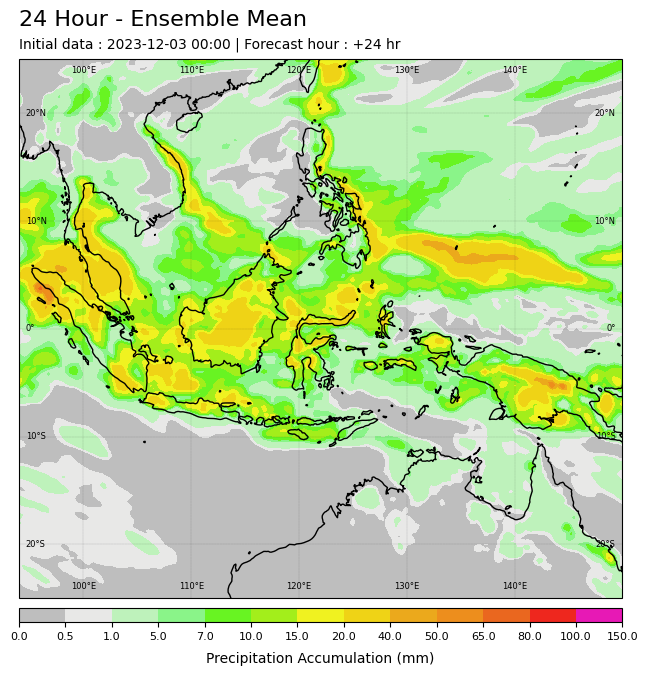

In [82]:
import matplotlib
fig, ax = plt.subplots(1, 1, figsize=(13, 7), subplot_kw={'projection': ccrs.PlateCarree()}) # initiate matplotlib figure

#Make colormap
clr_emean = ["#bebebe", "#e8e8e7", "#bdf2ba", "#88f487", "#68f422", "#a4ee1b", "#f2f220", "#efd216", "#eba91c",
                     "#ed8e1d", "#ea661f", "#ee251e", "#e719b5"]
lvl_emean = [0, 0.5, 1, 5, 7, 10, 15, 20, 40, 50, 65, 80, 100, 150]
cmap_emean = matplotlib.colors.LinearSegmentedColormap.from_list("", clr_emean)
cmap_emean.set_over("#e719b5")
cmap_emean.set_under("#bebebe")
norm_emean = matplotlib.colors.BoundaryNorm(lvl_emean, 256)

plot = ax.contourf(lons, lats, data, transform=ccrs.PlateCarree(), levels=lvl_emean, cmap=cmap_emean, norm=norm_emean, zorder=1)

# Add colorbar
pl,pb,pw,ph = ax.get_position().bounds
cbaxes = fig.add_axes([pl, pb-0.0339, pw, 0.02])  # l,b,w,h
cb = plt.colorbar(plot, cax=cbaxes, orientation='horizontal', ticks=lvl_emean)
cbaxes.tick_params(labelsize=8)

# Add coastlines
ax.coastlines(color='black', edgecolor='black')

# Add title and text
ax.set_title(f"24 Hour - Ensemble Mean", x=0, y=1.0, pad=24, fontsize=16, ha="left")
ax.text(x=0, y=1.02,
        s=f"Initial data : {init_date:%Y-%m-%d %H:%M} | Forecast hour : +{ftime} hr", size=10, ha="left", transform=ax.transAxes)
ax.text(x=0.5, y=-0.12, s="Precipitation Accumulation (mm)", size=10, ha="center", transform=ax.transAxes)

# Add gridlines
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.1, color='black', alpha=0.8, linestyle='--',
                  ypadding=-5, xpadding=-5)
gl.xlines = True
gl.xlabel_style = {'size': 6, 'color': 'black'}
gl.ylabel_style = {'size': 6, 'color': 'black'}

plt.savefig(f"emean_{init_date:%Y%m%d%H}_{ftime}.png",dpi=200,bbox_inches='tight')


Now it's your turn:
1. Make nice plot for ensemble median with the same colormap and save it. Hint: just change the "data" variable.
2. Make plot for probabilities with new colormap in the code block below and save it.

In [ ]:
# Colormap
clr_poe = ["#ffffff","#ccff33","#5dff00","#ffff66","#ff9933","#fa4632","#cc0033","#cc009b"]
lvl_poe = [0, 5, 10, 20, 40, 60, 80, 90, 100]
cmap_poe = matplotlib.colors.LinearSegmentedColormap.from_list("", clr_poe)
cmap_poe.set_over("#cc009b")
cmap_poe.set_under("#ffffff")
norm_poe = matplotlib.colors.BoundaryNorm(lvl_poe, 256)